<a href="https://colab.research.google.com/github/sourcecode369/unconventional-neural-networks/blob/master/deep-dreams/Deep_Dreams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import scipy
import keras
import keras.backend as K
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout
from IPython.display import display, clear_output
from PIL import Image

Using TensorFlow backend.


In [0]:
settings = {
    'features':{
        'mixed2':0.2,
        'mixed3':0.5,
        'mixed4':2.,
        'mixed5':1.5
    }
}

In [0]:
def download(url, target_size=None):
  # name = url.split('/')[-1]
  name = 'galaxy.jpg'
  image_path = keras.utils.get_file(name, origin=url)
  return image_path

In [0]:
def preprocess_image(x):
  img = image.load_img(x)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img

In [5]:
def deprocess_image(x):
  if K.image_data_format() == "channels_first":
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose(1,2,0)
  else:
    x = x.reshape((x.shape[1],x.shape[2],3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

In [6]:
model = InceptionV3(weights="imagenet", include_top=False)
dream = model.input
print("Model loaded.")












Model loaded.


In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [0]:
loss = K.variable(0.)

In [0]:
for layer_name in settings["features"]:
  if layer_name not in layer_dict:
    raise ValueError('Layer' + layer_name + 'not found in the model.')
  coeff = settings["features"][layer_name]
  x = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(x), 'float32'))
  if K.image_data_format() == "channels_first":
    loss = loss + coeff * K.sum(K.square(x[:,:,2:-2, 2:-2])) / scaling
  else:
    loss = loss + coeff * K.sum(K.square(x[:, 2:-2, 2:-2,:])) / scaling

In [0]:
grads = K.gradients(loss, dream)[0]

In [0]:
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

In [0]:
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [0]:
def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_value = outs[1]
  return loss_value, grad_value

In [0]:
def resize_img(img, size):
  img = np.copy(img)
  if K.image_data_format() == "channels_first":
    factors = (1, 1,
               float(size[0])/img.shape[2],
               float(size[1])/img.shape[3])
  else:
    factors = (1,
               float(size[0])/img.shape[1],
               float(size[1])/img.shape[2],
               1)
  return scipy.ndimage.zoom(img, factors, order=1)

In [0]:
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_value = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print(".. Loss value at", i, ":", loss_value)
    x += step * grad_value
  return x

In [0]:
step = 0.1
num_octave = 3
octave_scale = 1.4
num_iterations = 20
max_loss = 10

In [0]:
img = preprocess_image(download("https://www.sciencefriday.com/wp-content/uploads/2019/04/blackhole.jpg"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


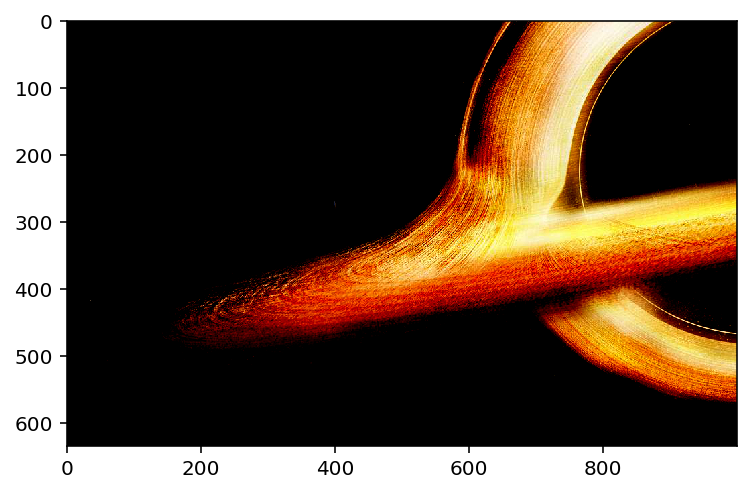

In [18]:
plt.imshow(img.squeeze())

In [0]:
if K.image_data_format() == "channels_first":
  original_shape = np.array(img).shape[2:]
else:
  original_shape = np.array(img).shape[1:3]

In [0]:
sucessive_shapes = [original_shape]

In [21]:
%%time
for i in range(1, num_octave + 1):
  shape = tuple([int(dim/(octave_scale**i)) for dim in original_shape])
  print("New Shape: {}".format(shape))
  sucessive_shapes.append(shape)

New Shape: (452, 714)
New Shape: (323, 510)
New Shape: (231, 364)
CPU times: user 737 µs, sys: 1.05 ms, total: 1.79 ms
Wall time: 6.27 ms


In [22]:
sucessive_shapes = sucessive_shapes[::-1]
print("Successive shape: {}".format(sucessive_shapes))

Successive shape: [(231, 364), (323, 510), (452, 714), (634, 1000)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


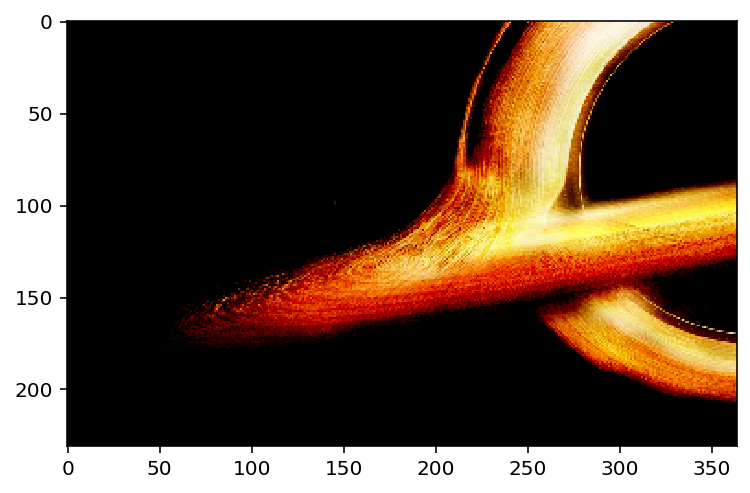

In [23]:
original_img = np.copy(img)
shrunk_original_img = resize_img(img, sucessive_shapes[0])
plt.imshow(shrunk_original_img.squeeze())

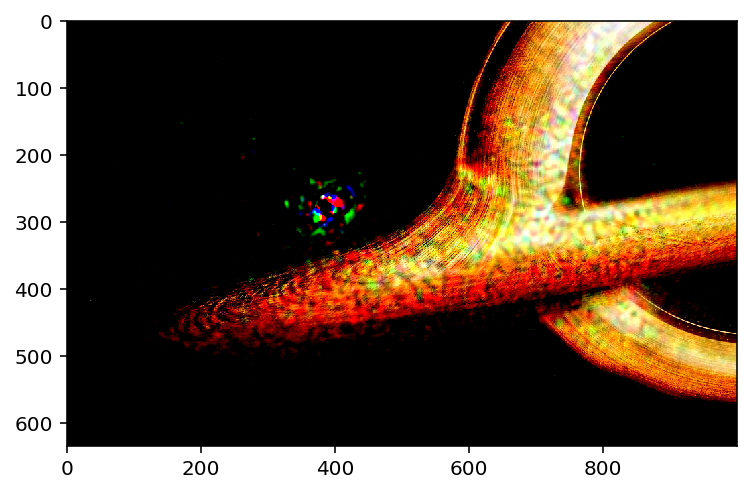

In [27]:
for shape in sucessive_shapes:
  print("Preprocessing image shape: ",shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img, iterations=200, step=step, max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)

  plt.imshow(img.squeeze())
  clear_output(wait=True)